# 1. Imports

In [1]:
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion, Pipeline

In [2]:
pip install pyod

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pyod

Requirement already up-to-date: pyod in c:\programdata\anaconda3\lib\site-packages (0.7.5)
Note: you may need to restart the kernel to use updated packages.


# 2. Data Reading

In [4]:
apps_df = pd.read_csv('./data/googleplaystore.csv', parse_dates=['Last Updated'], infer_datetime_format=True)
user_reviews_df = pd.read_csv('./data/googleplaystore_user_reviews.csv')

# 3. Data Exploration

In [5]:
apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
user_reviews_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


# 4. Data Cleaning

## A. Handling Noisy Data

### NOTE: Record 10472 has wrong inputs in `Category`, `Rating`, `Reviews`, `Size`, `Installs`, `Type`, `Price` thus it needs to be removed.

In [7]:
print(apps_df.loc[10472])
apps_df = apps_df.drop(10472)

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                                 19
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object


### I. Removing `M`, `k`, `Varies with device` from `Size` column

In [8]:
apps_df['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

In [9]:
# Removing `M`, Changing Size To KB
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        str(int(float(value.rstrip('M')) * 1024)) if value[-1] == 'M' else value
)

# Removing `k`
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        str(value.rstrip('k')) if value[-1] == 'k' else value
)

# Setting `Varies with device` to NaN
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        np.nan if value == 'Varies with device' else value
)

### II. Removing `+`, `,` from `Installs` column

In [10]:
apps_df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [11]:
# Removing `+`
apps_df['Installs'] = apps_df['Installs'].map(
    lambda value :
        value.rstrip('+')
)

# Removing `,`
apps_df['Installs'] = apps_df['Installs'].map(
    lambda value :
        ''.join(value.split(','))
)

### III. Removing `$` from `Price` column

In [12]:
apps_df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [13]:
# Removing `$`
apps_df['Price'] = apps_df['Price'].map(
    lambda value :
        value.lstrip('$')
)

### IV. Changing Columns To Numeric

In [14]:
apps_df.describe()

,Rating
count,9366.000000
mean,4.191757
std,0.515219
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


In [15]:
# Changing Values From String To Numeric in `Rating` Column
apps_df['Rating'] = pd.to_numeric(apps_df['Rating'])

# Changing Values From String To Numeric In `Reviews` Column
apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'])

# Changing Values From String To Numeric in `Size` Column
apps_df['Size'] = pd.to_numeric(apps_df['Size'])

# Changing Values From String To Numeric in `Installs` Column
apps_df['Installs'] = pd.to_numeric(apps_df['Installs'])

# Changing Values From String To Numeric in `Price` Column
apps_df['Price'] = pd.to_numeric(apps_df['Price'])

In [16]:
apps_df.describe()

,Rating,Reviews,Size,Installs,Price
count,9366.000000,1.084000e+04,9145.000000,1.084000e+04,10840.000000
mean,4.191757,4.441529e+05,22032.397212,1.546434e+07,1.027368
std,0.515219,2.927761e+06,23131.336868,8.502936e+07,15.949703
min,1.000000,0.000000e+00,8.500000,0.000000e+00,0.000000
25%,4.000000,3.800000e+01,5017.000000,1.000000e+03,0.000000
50%,4.300000,2.094000e+03,13312.000000,1.000000e+05,0.000000
75%,4.500000,5.477550e+04,30720.000000,5.000000e+06,0.000000
max,5.000000,7.815831e+07,102400.000000,1.000000e+09,400.000000


### Special Cases

In [17]:
# Should I handle Outliers?
# In Type there is 2 Unrated, 3 Adults +18. should they be removed?

## B. Handling Missing Values

In [18]:
missing_count = apps_df.isna().sum()

missing_count

App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

### I. Replacing `NaN` with `Free`, `Paid` in `Type` Column based on `Price` Column

In [19]:
apps_df['Type'].value_counts().head()

Free    10039
Paid      800
Name: Type, dtype: int64

In [20]:
# Replacing `NaN`
apps_df['Type'] = np.where(apps_df['Price'] == 0, 'Free', 'Paid')

### II. Replacing `NaN` with `1.0` in `Current Ver` Column

In [21]:
apps_df['Current Ver'].value_counts().head()

Varies with device    1459
1.0                    809
1.1                    264
1.2                    178
2.0                    151
Name: Current Ver, dtype: int64

In [22]:
# Replacing `NaN`
apps_df['Current Ver'] = apps_df['Current Ver'].fillna('1.0')

### III. Replacing `NaN` with Most Repeated Value in `Android Ver` Column

In [23]:
apps_df['Android Ver'].value_counts().head()

4.1 and up            2451
4.0.3 and up          1501
4.0 and up            1375
Varies with device    1362
4.4 and up             980
Name: Android Ver, dtype: int64

In [24]:
# Replacing `NaN`
apps_df['Android Ver'] = apps_df['Android Ver'].fillna(apps_df['Android Ver'].value_counts().idxmax())

### IV. Replacing `NaN` in `Size` with the Mean of the `Category` of missing value

In [25]:
mean_sizes = apps_df.groupby('Category').mean()['Size']

apps_df.loc[apps_df['Size'].isna(), 'Size'] = mean_sizes[apps_df.loc[apps_df['Size'].isna(), 'Category'].values].values

### Re-Check

In [26]:
missing_count = apps_df.isna().sum()

missing_count

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          0
Android Ver          0
dtype: int64

### User Reviews Table was NOT handled!

### IV. Outlier Detection

In [27]:
from pyod.models.hbos import HBOS 
from pyod.models.cblof import CBLOF 
from pyod.models.knn import KNN 
from pyod.models.lof import LOF

outliers_fraction = 0.05

detectors = [
    HBOS(contamination=outliers_fraction),
    LOF(contamination=outliers_fraction),
    CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=42),
    KNN(contamination=outliers_fraction),
    KNN(method='mean',contamination=outliers_fraction)
]

In [28]:
# testing outlier detection for now
outlier_detection_df = apps_df.copy()
outlier_detection_df.drop(columns=['App', 'Rating', 'Current Ver', 'Last Updated', 'Android Ver', 'Category', 'Type', 'Content Rating', 
                                  'Genres', 'Size'], inplace=True)
outlier_detection_df.head()

,Reviews,Installs,Price
0,159,10000,0.0
1,967,500000,0.0
2,87510,5000000,0.0
3,215644,50000000,0.0
4,967,100000,0.0


In [29]:
list_of_names = []
for detector in detectors:
    print(detector)
    detector.fit(outlier_detection_df)
    predictions = detector.predict(outlier_detection_df)
    print('Found ', apps_df[predictions == 1].shape[0], ' outliers.')
    list_of_names.append(apps_df[predictions == 1]['App'].copy())

HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)
Found  204  outliers.
LOF(algorithm='auto', contamination=0.05, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, p=2)
Found  468  outliers.
CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False)
Found  542  outliers.
KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)
Found  460  outliers.
KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)
Found  419  outliers.


In [30]:
merged_df = list_of_names[0]
for df in list_of_names[1:]:
    merged_df = pd.merge(merged_df, df, how='outer', on=['App'])
merged_df['App'].unique().shape

(775,)

# 5. Data Visualization

## A. Histograms

### I. Histogram of `Rating` Columns

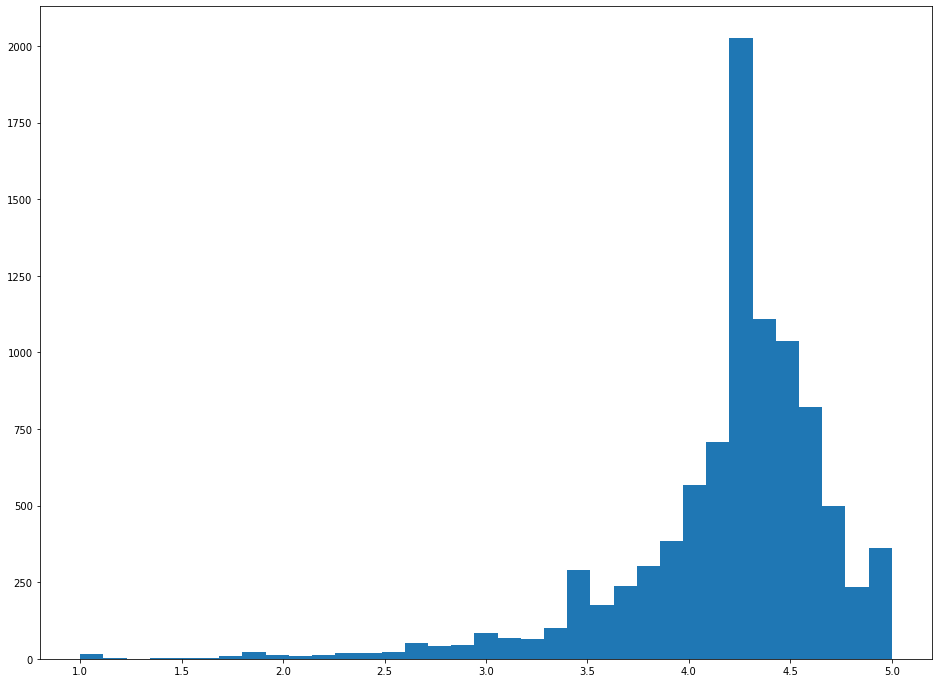

In [31]:
_ = apps_df['Rating'].hist(grid = False, figsize=(16,12), bins = 35)

### II. Histogram of `Reviews` Columns

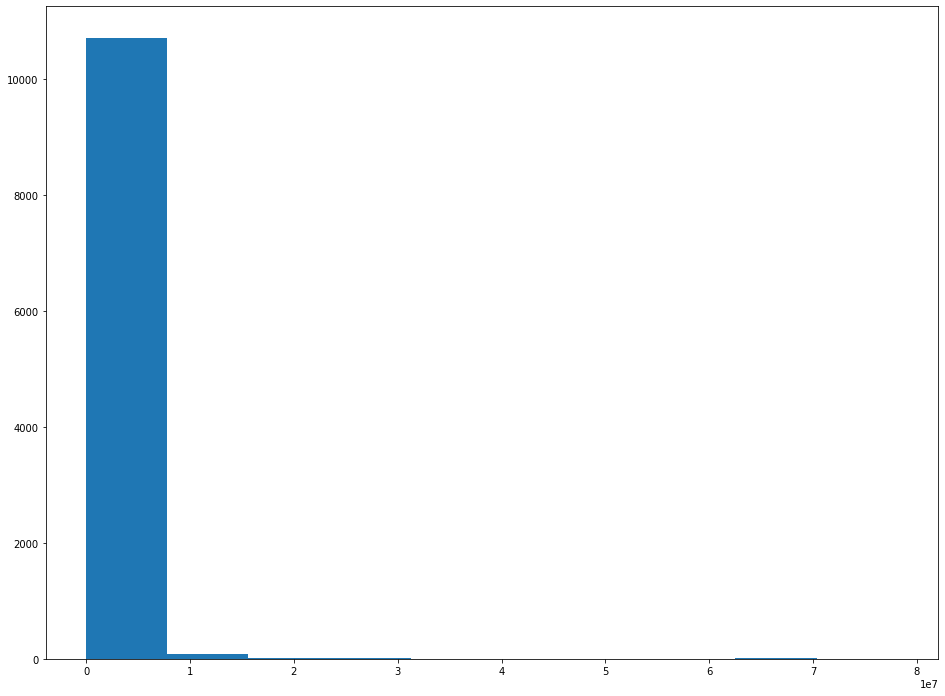

In [32]:
_ = apps_df['Reviews'].hist(grid = False, figsize=(16,12), bins = 10)

### III. Histogram of `Size` Columns

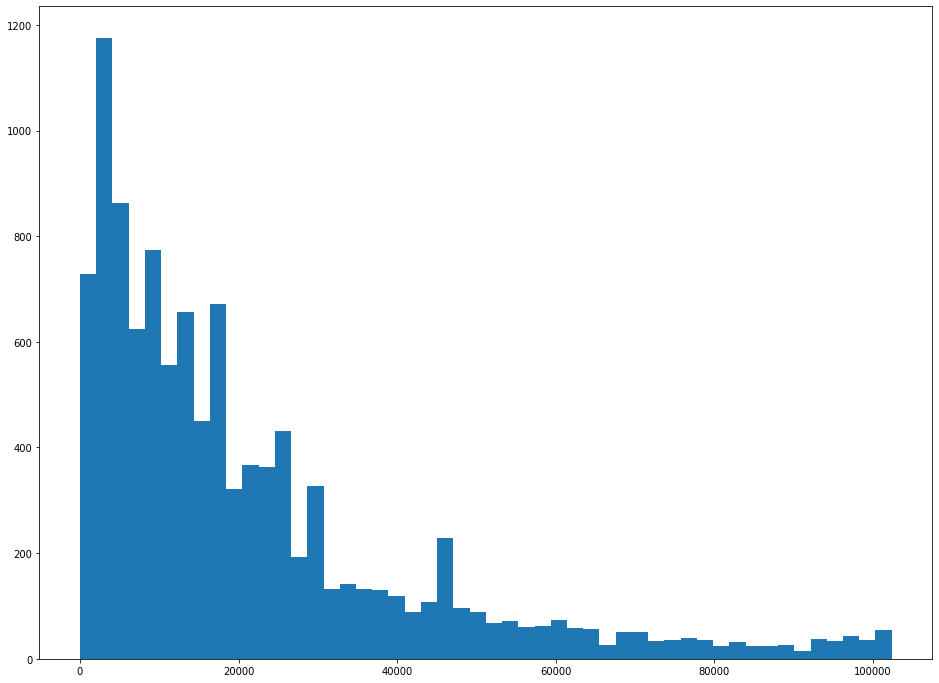

In [33]:
_ = apps_df['Size'].hist(grid = False, figsize=(16,12), bins = 50)

### IV. Histogram of `Installs` Columns

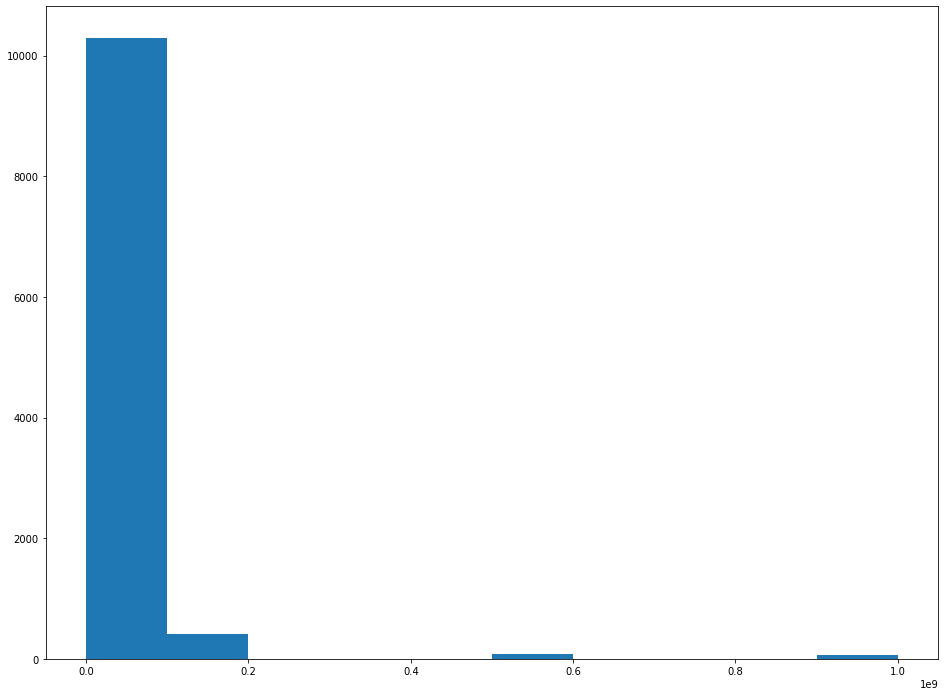

In [34]:
_ = apps_df['Installs'].hist(grid = False, figsize=(16,12), bins = 10)

## B. Bar Graphs

### I. Relation between `Category` & mean of `Size` Columns

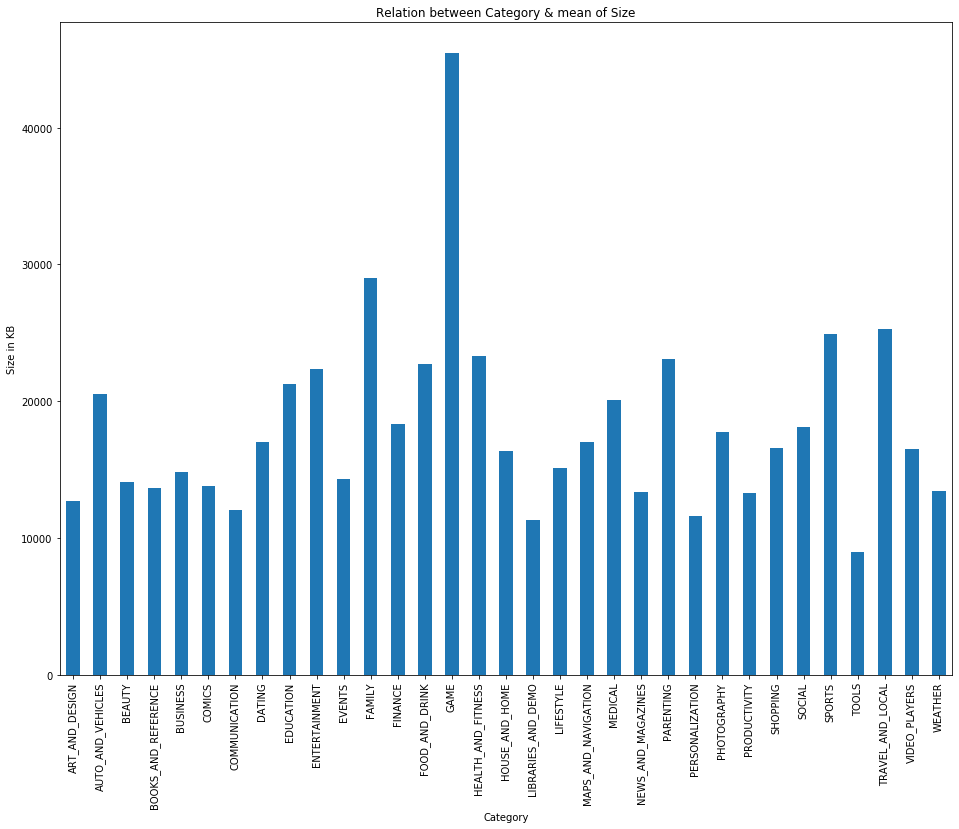

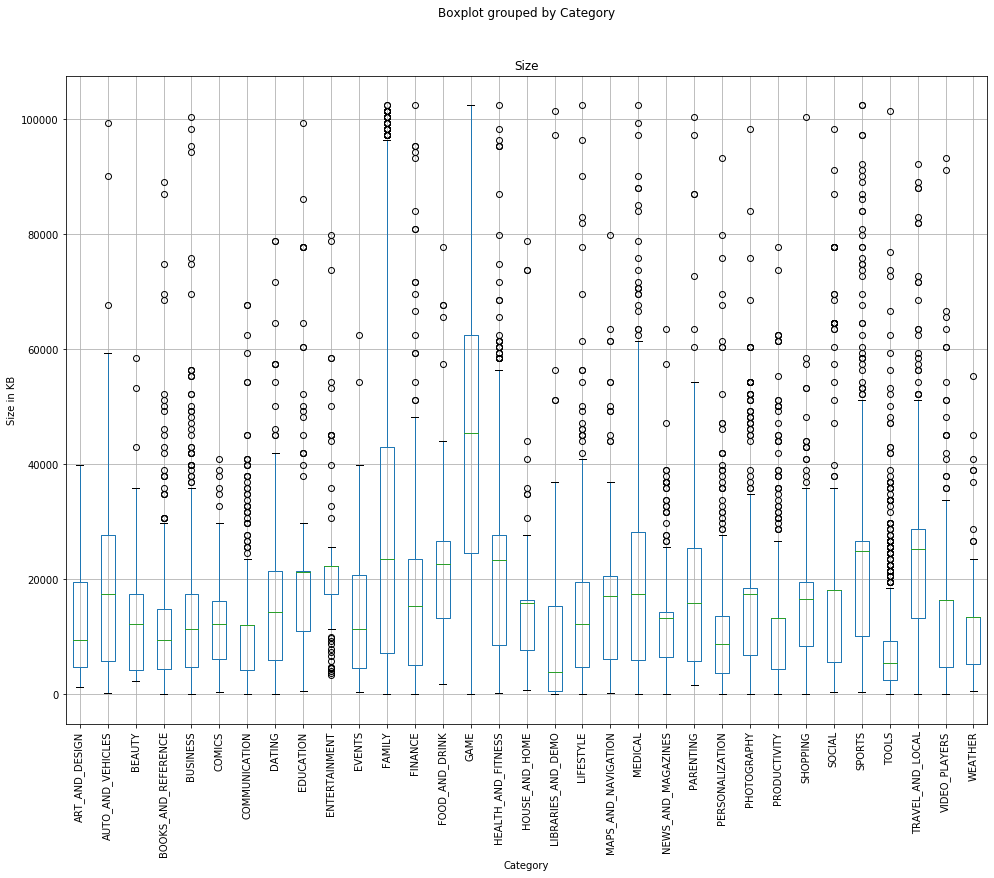

In [35]:
_ = apps_df.groupby('Category')['Size'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Size in KB')
_ = plt.title('Relation between Category & mean of Size')

_ = apps_df.boxplot(column='Size', by='Category', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### II. Relation between `Category` & mean of `Installs` Columns

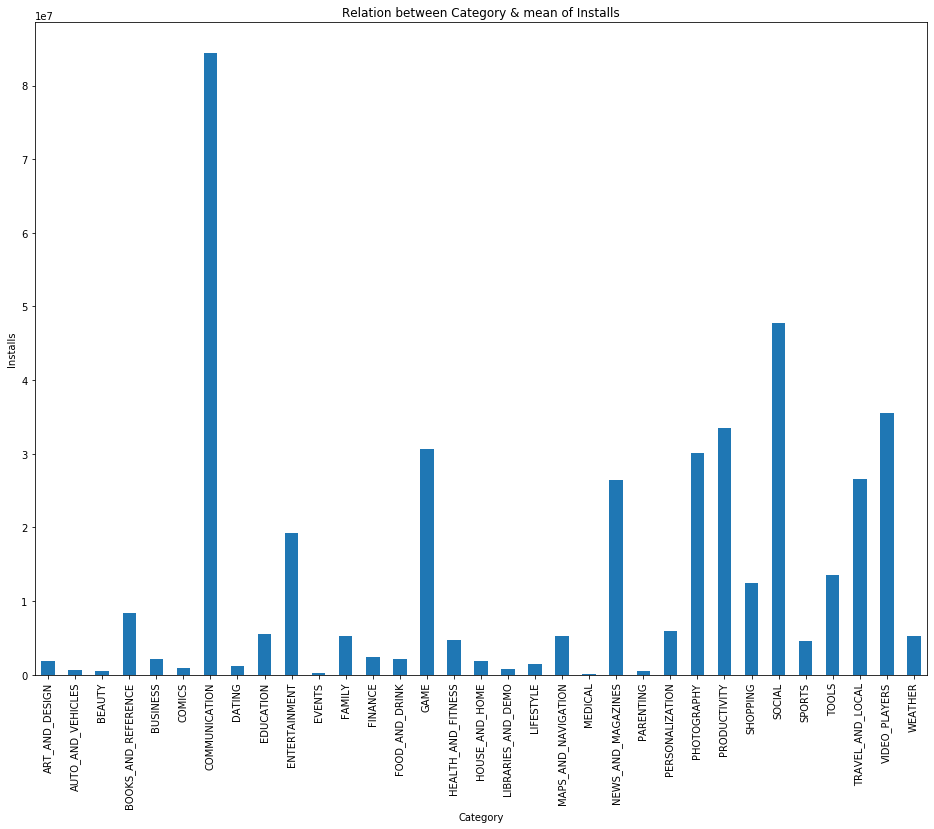

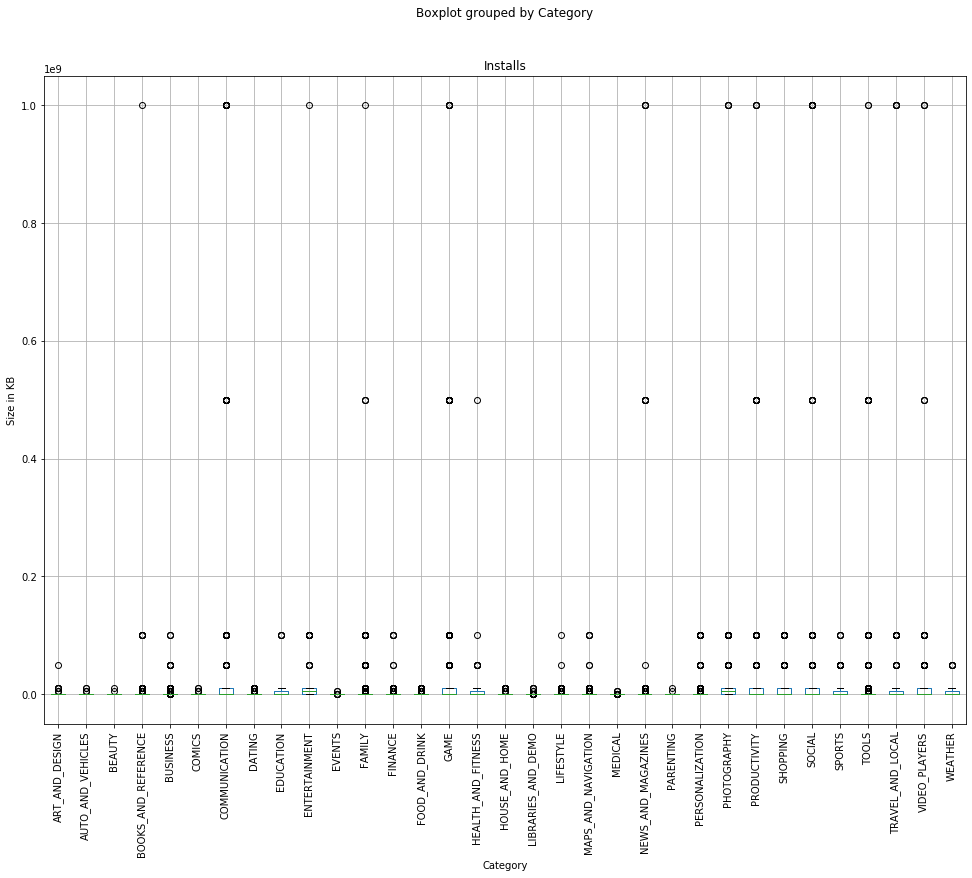

In [36]:
_ = apps_df.groupby('Category')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Category & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Category', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### III. Relation between `Type` & mean of `Installs` Columns

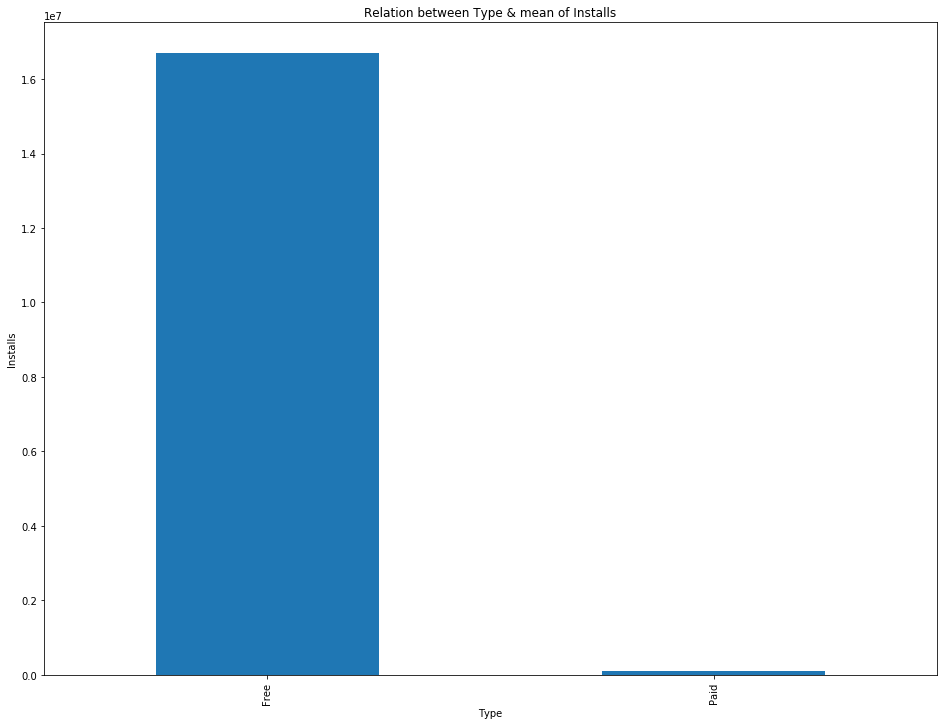

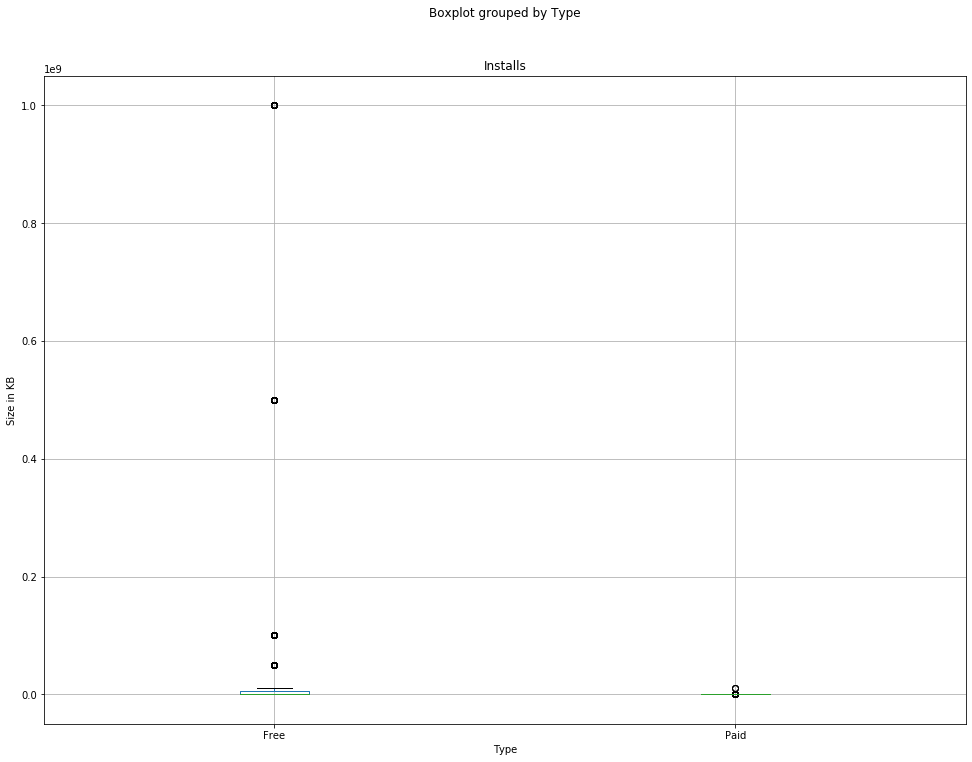

In [37]:
_ = apps_df.groupby('Type')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Type & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Type', figsize=(16,12))
_ = plt.ylabel('Size in KB')

### IV. Relation between `Rating` & mean of `Reviews` Columns

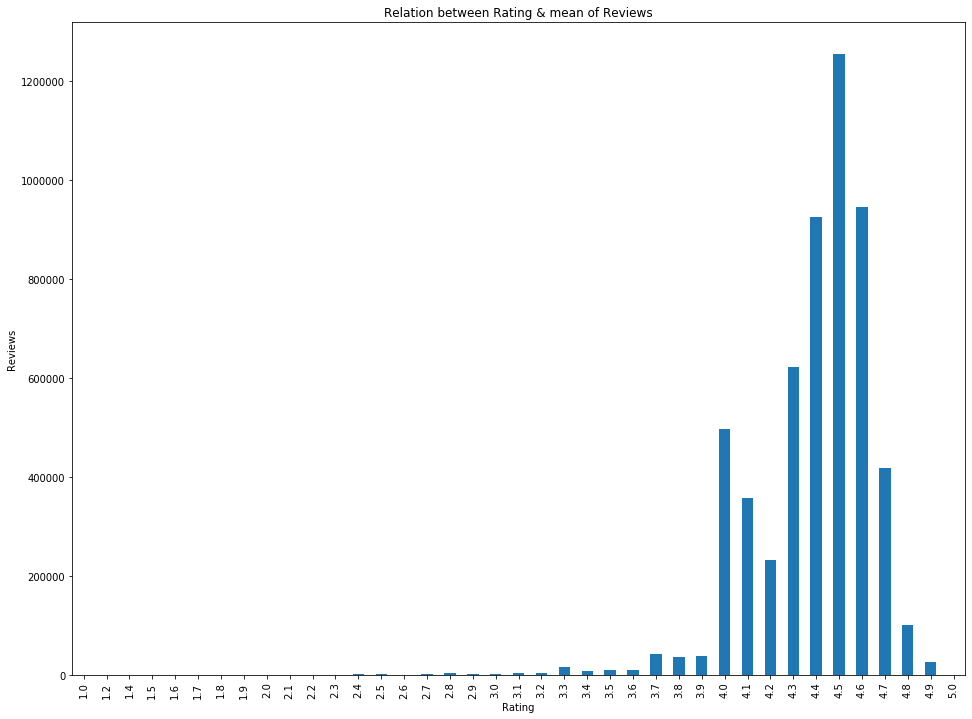

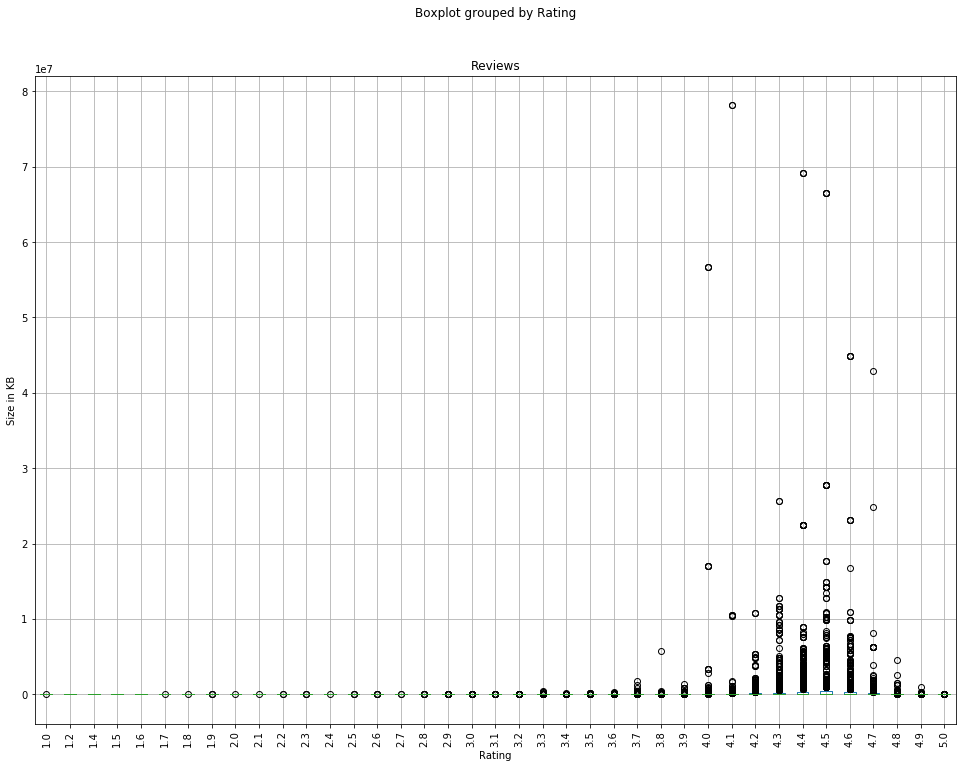

In [38]:
_ = apps_df.groupby('Rating')['Reviews'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Reviews')
_ = plt.title('Relation between Rating & mean of Reviews')

_ = apps_df.boxplot(column='Reviews', by='Rating', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### V. Relation between `Rating` & mean of `Installs` Columns

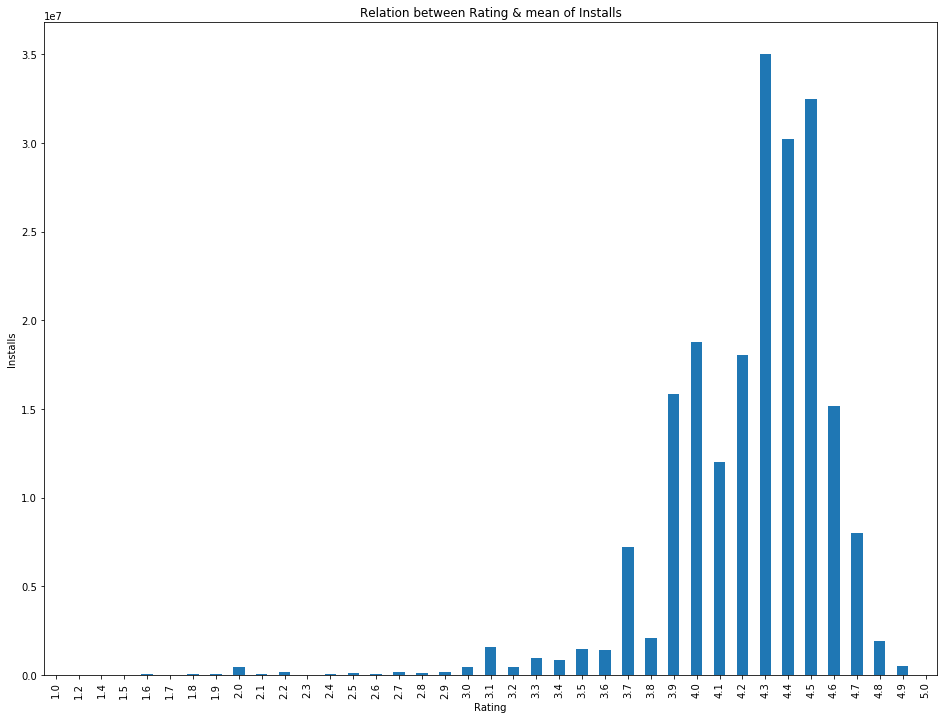

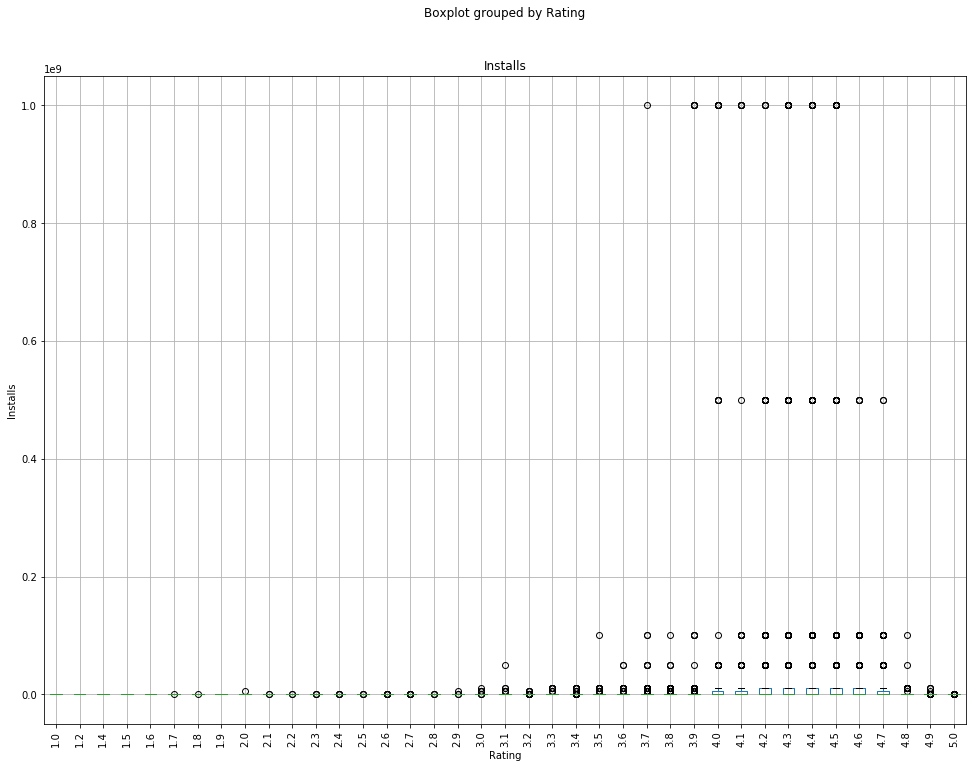

In [39]:
_ = apps_df.groupby('Rating')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Rating & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Rating', figsize=(16,12), rot = 90)
_ = plt.ylabel('Installs')

## C. Correlation Matrix between all numerical columns

#### Scatter Plot

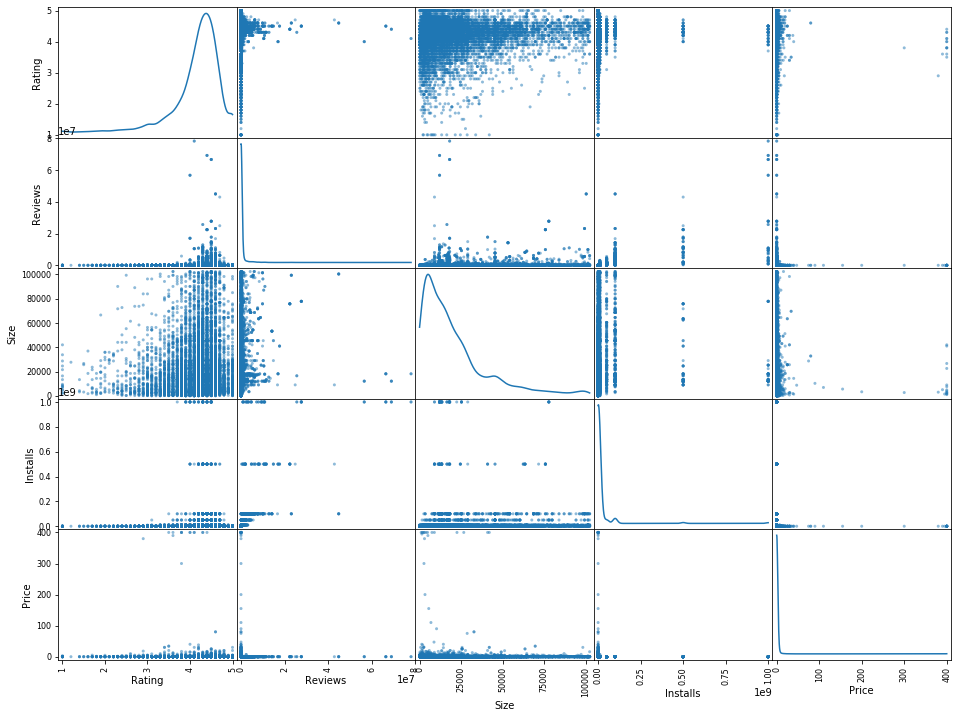

In [40]:
_ = pd.plotting.scatter_matrix(apps_df[apps_df.describe().columns], figsize=(16,12), diagonal='kde')

#### Heat Map

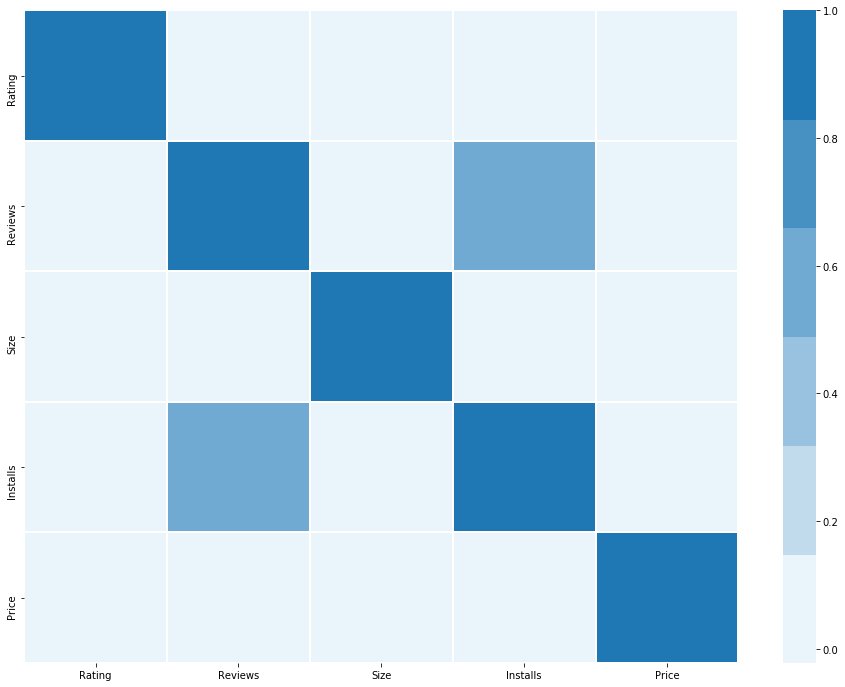

In [41]:
plt.subplots(figsize=(16, 12))
_ = sns.heatmap(
    apps_df[apps_df.describe().columns].corr(),
    cmap = sns.light_palette((31 / 255, 119 / 255, 180 / 255)),
    linewidths = 1
)

# 6. Data Transformation & Feature Engineering

## A. Encoding Data

#### Helper function: One-hot encoder by column name

In [42]:
def one_hot_encode_column(dataframe, column_name, prefix=''):
    dataframe[column_name] = pd.Categorical(dataframe[column_name])
    dummy_values = pd.get_dummies(dataframe[column_name], prefix = column_name + '_' + prefix if prefix != '' else column_name)
    dataframe = pd.concat([dataframe, dummy_values], axis=1)
    dataframe = dataframe.drop(column_name, axis=1)
    
    return dataframe

### I. One-hot encoding the `Type` column

In [43]:
apps_df = one_hot_encode_column(apps_df, 'Type')

apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Type_Free,Type_Paid
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19456.0,10000,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14336.0,500000,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8908.0,5000000,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25600.0,50000000,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1,0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2867.0,100000,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,1,0


### II. One-hot encoding the `Category` column

In [44]:
apps_df = one_hot_encode_column(apps_df, 'Category')

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,500000,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,5000000,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,100000,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,...,0,0,0,0,0,0,0,0,0,0


### III. One-hot encoding the `Content Rating` column

In [45]:
apps_df = one_hot_encode_column(apps_df, 'Content Rating')

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Genres,Last Updated,Current Ver,Android Ver,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,0.0,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,...,0,0,0,0,0,1,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,500000,0.0,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,...,0,0,0,0,0,1,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,5000000,0.0,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,...,0,0,0,0,0,1,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,0.0,Art & Design,"June 8, 2018",Varies with device,4.2 and up,...,0,0,0,0,0,0,0,0,1,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,100000,0.0,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,...,0,0,0,0,0,1,0,0,0,0


### IV. One-hot encoding the `Genres` column after delimiting values by semicolons

In [46]:
# Collect all unique values in column and join them by a semicolon
joined_unique_values = ';'.join(apps_df['Genres'].unique().tolist())

# Split again using the semicolon and add into a set to remove duplicates
set_of_genres = set(joined_unique_values.split(';'))

# Loop over the set of genres, setting the values to one if the genre name exist in the Genres column
for genre in set_of_genres:
    apps_df['Genre_' + genre] = apps_df['Genres'].map(lambda value: 1 if genre in value.split(';') else 0)

# Drop the Genres column
apps_df = apps_df.drop('Genres', axis=1)

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Last Updated,Current Ver,Android Ver,Type_Free,...,Genre_Art & Design,Genre_Adventure,Genre_Books & Reference,Genre_Health & Fitness,Genre_Trivia,Genre_Libraries & Demo,Genre_Medical,Genre_Entertainment,Genre_Creativity,Genre_Casino
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,0.0,"January 7, 2018",1.0.0,4.0.3 and up,1,...,1,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,500000,0.0,"January 15, 2018",2.0.0,4.0.3 and up,1,...,1,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,5000000,0.0,"August 1, 2018",1.2.4,4.0.3 and up,1,...,1,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,0.0,"June 8, 2018",Varies with device,4.2 and up,1,...,1,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,100000,0.0,"June 20, 2018",1.1,4.4 and up,1,...,1,0,0,0,0,0,0,0,1,0


### V. Categorise the `Installs` ordinally

In [47]:
ord = OrdinalEncoder()
apps_df['Installs'] = ord.fit_transform(apps_df['Installs'].values.reshape(-1, 1))

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Last Updated,Current Ver,Android Ver,Type_Free,...,Genre_Art & Design,Genre_Adventure,Genre_Books & Reference,Genre_Health & Fitness,Genre_Trivia,Genre_Libraries & Demo,Genre_Medical,Genre_Entertainment,Genre_Creativity,Genre_Casino
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,9.0,0.0,"January 7, 2018",1.0.0,4.0.3 and up,1,...,1,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,12.0,0.0,"January 15, 2018",2.0.0,4.0.3 and up,1,...,1,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,14.0,0.0,"August 1, 2018",1.2.4,4.0.3 and up,1,...,1,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,16.0,0.0,"June 8, 2018",Varies with device,4.2 and up,1,...,1,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,11.0,0.0,"June 20, 2018",1.1,4.4 and up,1,...,1,0,0,0,0,0,0,0,1,0


## B. Dropping unneeded columns

### I. Dropping  `App`, `Current Ver`, and `Android Ver` columns

In [48]:
apps_df = apps_df.drop(['App', 'Current Ver', 'Android Ver'], axis=1)

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Last Updated,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genre_Art & Design,Genre_Adventure,Genre_Books & Reference,Genre_Health & Fitness,Genre_Trivia,Genre_Libraries & Demo,Genre_Medical,Genre_Entertainment,Genre_Creativity,Genre_Casino
0,4.1,159,19456.0,9.0,0.0,"January 7, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,3.9,967,14336.0,12.0,0.0,"January 15, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,4.7,87510,8908.0,14.0,0.0,"August 1, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,4.5,215644,25600.0,16.0,0.0,"June 8, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,4.3,967,2867.0,11.0,0.0,"June 20, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,1,0


## C. Data Scaling

### I. Scaling the `Size` column

In [49]:
scaler = StandardScaler()
apps_df['Size'] = scaler.fit_transform(apps_df['Size'].values.reshape(-1, 1))

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Last Updated,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genre_Art & Design,Genre_Adventure,Genre_Books & Reference,Genre_Health & Fitness,Genre_Trivia,Genre_Libraries & Demo,Genre_Medical,Genre_Entertainment,Genre_Creativity,Genre_Casino
0,4.1,159,-0.104941,9.0,0.0,"January 7, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,3.9,967,-0.342423,12.0,0.0,"January 15, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,4.7,87510,-0.594191,14.0,0.0,"August 1, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,4.5,215644,0.180038,16.0,0.0,"June 8, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,4.3,967,-0.874392,11.0,0.0,"June 20, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,1,0


### II. Scaling the `Reviews` column

In [50]:
scaler = StandardScaler()
apps_df['Reviews'] = scaler.fit_transform(apps_df['Reviews'].values.reshape(-1, 1))

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Last Updated,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genre_Art & Design,Genre_Adventure,Genre_Books & Reference,Genre_Health & Fitness,Genre_Trivia,Genre_Libraries & Demo,Genre_Medical,Genre_Entertainment,Genre_Creativity,Genre_Casino
0,4.1,-0.151657,-0.104941,9.0,0.0,"January 7, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,3.9,-0.151381,-0.342423,12.0,0.0,"January 15, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,4.7,-0.121820,-0.594191,14.0,0.0,"August 1, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,4.5,-0.078053,0.180038,16.0,0.0,"June 8, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,4.3,-0.151381,-0.874392,11.0,0.0,"June 20, 2018",1,0,1,0,...,1,0,0,0,0,0,0,0,1,0


## D. Other Transformations

### I. Convert `Last Updated` column to a numerical column representing months since updating

In [51]:
apps_df['Last Updated (Months)'] = apps_df['Last Updated'].map(
    lambda value: (pd.datetime.now().date() - pd.to_datetime(value).date()).days // 30)
apps_df = apps_df.drop('Last Updated', axis=1)

apps_df['Last Updated (Months)'] = scaler.fit_transform(apps_df['Last Updated (Months)'].values.reshape(-1, 1))

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,...,Genre_Adventure,Genre_Books & Reference,Genre_Health & Fitness,Genre_Trivia,Genre_Libraries & Demo,Genre_Medical,Genre_Entertainment,Genre_Creativity,Genre_Casino,Last Updated (Months)
0,4.1,-0.151657,-0.104941,9.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.090205
1,3.9,-0.151381,-0.342423,12.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.166388
2,4.7,-0.121820,-0.594191,14.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.623490
3,4.5,-0.078053,0.180038,16.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.471123
4,4.3,-0.151381,-0.874392,11.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,-0.547307


# 7. Data Pipeline Implementation

#### Pipeline Inputs

In [52]:
nums = ['Size', 'Price', 'Reviews']
cats = ['Type', 'Category', 'Content Rating', 'Genres', 'Installs']

normal_encoding = ['Type', 'Category', 'Content Rating']
ordinal_encoding = ['Installs']
custom_encoding = ['Genres']

## A. Head Pipeline

### I. Data Cleaner

In [53]:
class DataCleaner(BaseEstimator, TransformerMixin):
    bad_rows: list

    def __init__(self, rows_to_delete):
        self.bad_rows = rows_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        assert isinstance(X, pd.DataFrame)

        X = X.drop(self.bad_rows)
        X['Current Ver'] = X['Current Ver'].fillna('1.0')
        X['Android Ver'] = X['Android Ver'].fillna(X['Android Ver'].value_counts().idxmax())
        X['Type'] = np.where(X['Price'] == 0, 'Free', 'Paid')

        return X

### II. Data Pre-processing

In [54]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    numerical_columns: list
    categorical_columns: list

    def __init__(self, numericals, categoricals):
        self.numerical_columns = numericals
        self.categorical_columns = categoricals

    def fit(self, X, y=None):
        return self

    def preprocess_size(self, value):
        if value[-1] == 'M':
            number = int(float(value.rstrip('M')) * 1024)
            return str(number)
        elif value[-1] == 'k':
            return str(value.rstrip('k'))
        elif value == 'Varies with device':
            return np.nan
        else:
            return value

    def preprocess_installs(self, value):
        value = value.rstrip('+')
        value = ''.join(value.split(','))

        return value

    def cast_numerical_columns(self, dataframe):
        types = dict(zip_longest(self.numerical_columns, ['float'], fillvalue='float'))
        dataframe = dataframe.astype(types)
        return dataframe

    def cast_categorical_columns(self, dataframe):
        for category in self.categorical_columns:
            dataframe[category] = pd.Categorical(dataframe[category])

        return dataframe

    def transform(self, X: pd.DataFrame):
        assert isinstance(X, pd.DataFrame)

        X['Size'] = X['Size'].apply(self.preprocess_size)

        X['Installs'] = X['Installs'].apply(self.preprocess_installs)

        X['Price'] = X['Price'].map(lambda value: value.lstrip('$'))

        X = self.cast_numerical_columns(X)
        X = self.cast_categorical_columns(X)

        return X

### III. Custom Imputer

In [55]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        mean_sizes = X.groupby('Category').mean()['Size']

        X.loc[X['Size'].isna(), 'Size'] = mean_sizes[X.loc[X['Size'].isna(), 'Category'].values].values
        return X

### IV. Feature Engineering

In [56]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X['Last Updated (Months)'] = X['Last Updated'].map(
            lambda value: (pd.datetime.now().date() - pd.to_datetime(value).date()).days // 30)
        X = X.drop('Last Updated', axis=1)
        X['Last Updated (Months)'] = pd.to_numeric(X['Last Updated (Months)'])

        return X

### V. Dataframe Splitter

In [57]:
class DataframeSplitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        numeric = X.select_dtypes(include=['number'])
        categorical = X.select_dtypes(include=['category'])

        return {'num': numeric, 'cat': categorical}


## Putting it all together

In [58]:
head_pipeline = Pipeline(steps=[
    ('cleaner', DataCleaner([10472])),
    ('preprocess', DataPreprocessor(nums, cats)),
    ('impute', CustomImputer()),
    ('engineer', FeatureEngineer()),
    ('splitter', DataframeSplitter())
], verbose=True)

## B. Transformers

#### Helper Transformer #1: Type Filter

In [59]:
class TypeFilter(BaseEstimator, TransformerMixin):
    def __init__(self, type):
        assert type == 'num' or type == 'cat'
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, dict)
        return X[self.type]

#### Helper Transformer #2: Column Filter

In [60]:
class ColumnFilter(BaseEstimator, TransformerMixin):
    list: list

    def __init__(self, col_list):
        self.list = col_list

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.list]

### I. Numerical Pipeline

In [61]:
numerical_pipeline = Pipeline(steps=[
    ('num_filter', TypeFilter('num')),
    ('scale', StandardScaler())
], verbose=True)

### II. Categorical Pipeline

#### Custom Encoder

In [62]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        assert isinstance(X, pd.DataFrame)

        # Collect all unique values in column and join them by a semicolon
        joined_unique_values = ';'.join(X['Genres'].unique().tolist())

        # Split again using the semicolon and add into a set to remove duplicates
        set_of_genres = set(joined_unique_values.split(';'))

        # Loop over the set of genres, setting the values to one if the genre name exist in the Genres column
        for genre in set_of_genres:
            X['Genre_' + genre] = X['Genres'].map(lambda value: 1 if genre in value.split(';') else 0)

        # Drop the Genres column
        X = X.drop('Genres', axis=1)

        return X.values

#### Full Pipeline

In [63]:
categorical_pipeline = Pipeline(steps=[
    ('cat_filter', TypeFilter('cat')),
    ('encoders', FeatureUnion(
        transformer_list=[('one_hots', Pipeline(steps=[('get_ones', ColumnFilter(normal_encoding)),
                                                       ('one_hot_encoder', OneHotEncoder())], verbose=True)),
                          ('ord_encs', Pipeline(steps=[('get_ords', ColumnFilter(ordinal_encoding)),
                                                       ('ordical_encoder', OrdinalEncoder())], verbose=True)),
                          ('cust_encs', Pipeline(steps=[('get_label_cols', ColumnFilter(custom_encoding)),
                                                        ('cust_label_encoder', CustomEncoder())], verbose=True))]
    ))
], verbose=True)

## C. Putting it all together

In [64]:
full_pipeline = Pipeline(steps=[('head', head_pipeline),
                                ('transformers', FeatureUnion(
                                    transformer_list=[
                                        ('numerical', numerical_pipeline),
                                        ('categorical', categorical_pipeline)
                                    ]))])